In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import requests
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [2]:
#Import electricity usage data
#Data begins January 23rd 2018 at midnight
from numpy import genfromtxt
usage = genfromtxt('usage.csv', delimiter=',')
usage.shape

(8639,)

In [4]:
#Get historical energy price data from ComEd
#Data begins January 23rd 2018 and ends February 23rd at midnight
r = requests.get('https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201801230000&dateend=201802230000&format=json')
print(r)

<Response [200]>


In [5]:
#Put price data into list
obj = r.json()
pricetemp = []
temp = []
for i in range(len(obj)):
    pricetemp.append(obj[i]['price'])
pricetemp = list(reversed(pricetemp))
price = pricetemp[:-(len(pricetemp)%12)]

In [6]:
#Get hourly data as average of 12 consecutive 5-minute interval prices
price = np.array(price).astype(np.float)
price = np.nanmean(price.reshape(-1, 12), axis=1)
price.shape

(715,)

In [7]:
#Shorten Usage data to correspond to price data
usagesmall = usage[0:len(price)]
usagesmall.shape

(715,)

In [8]:
#Find correlation between price and usage
priceusagecor, pval = pearsonr(price,usagesmall)
print(priceusagecor,pval)

0.09737167275217826 0.009179223505801245


In [9]:
#Arima Modeling Imports:
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error


In [10]:
#Remove 24 hours from data to make a test set and a train set
testsize = 24
trainprice = price[:-testsize].tolist()
testprice = price[-testsize:].tolist()
trainusage = usagesmall[:-testsize].tolist()
testusage = usagesmall[-testsize:].tolist()

In [11]:
#Use Arima Model to fit price data
pricemodel = sm.tsa.statespace.SARIMAX(endog = trainprice, order=(1,1,3),seasonal_order=(1,1,1,24))
pricemodel_fit = pricemodel.fit(disp=0)
print(pricemodel_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  691
Model:             SARIMAX(1, 1, 3)x(1, 1, 1, 24)   Log Likelihood                -844.373
Date:                            Thu, 04 Apr 2019   AIC                           1702.746
Time:                                    20:49:18   BIC                           1734.255
Sample:                                         0   HQIC                          1714.954
                                            - 691                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9755      0.049    -19.939      0.000      -1.071      -0.880
ma.L1          0.3779      0.053   

In [12]:
#Use Arima Model to fit usage data
usagemodel = sm.tsa.statespace.SARIMAX(endog = trainusage, order=(1,1,1),seasonal_order=(1,1,1,24))
usagemodel_fit = usagemodel.fit(disp=0)
print(usagemodel_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  691
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                 253.653
Date:                            Thu, 04 Apr 2019   AIC                           -497.305
Time:                                    20:49:26   BIC                           -474.799
Sample:                                         0   HQIC                          -488.585
                                            - 691                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5121      0.049     10.363      0.000       0.415       0.609
ma.L1         -0.8261      0.036   

0.2121656658348304


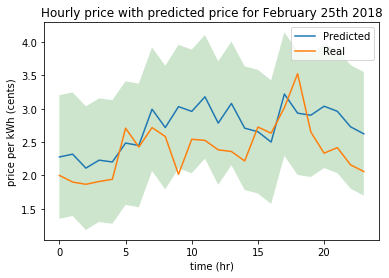

In [13]:
#Plot prediction of price data
predprice = pricemodel_fit.predict(start = len(trainprice), end = len(trainprice)-1 +testsize, dynamic = True)
pricemax = np.array(predprice) + np.std(trainprice)
pricemin = np.array(predprice) - np.std(trainprice)

hr = np.arange(testsize)
print(mean_squared_error(predprice,testprice))
fig, ax = plt.subplots()
predicted, = plt.plot(hr, predprice)
real, = plt.plot(hr,testprice)
plt.xlabel('time (hr)')
plt.ylabel('price per kWh (cents)')
plt.title('Hourly price with predicted price for February 25th 2018')
plt.legend([predicted,real],['Predicted','Real'])
ax.fill_between(hr,pricemax, pricemin,facecolor='green', alpha=0.2,)
plt.show()
#plt.savefig('pricepred')

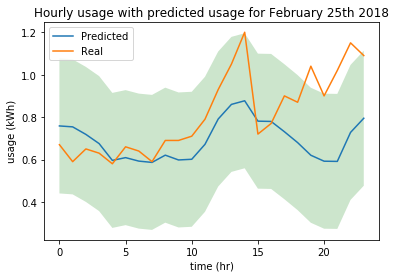

In [14]:
#Plot prediction of usage data
predusage = usagemodel_fit.predict(start = len(trainusage), end = len(trainusage)-1 +testsize, dynamic = True)
usagemax = np.array(predusage) + np.std(trainusage)
usagemin = np.array(predusage) - np.std(trainusage)

#print(mean_squared_error(predusage,testusage))
fig, ax = plt.subplots()
predicted, = plt.plot(hr, predusage)
real, = plt.plot(hr,testusage)
plt.xlabel('time (hr)')
plt.ylabel('usage (kWh)')
plt.title('Hourly usage with predicted usage for February 25th 2018')
plt.legend([predicted,real],['Predicted','Real'])
ax.fill_between(hr,usagemax, usagemin,facecolor='green', alpha=0.2,)
plt.show()
#plt.savefig('UsagePred')

In [15]:
#Assuming we are using a powerwall, plan battery usage
#We assume we have 14 kwh of storage and can charge or release 5kw at a time. 
#We assume no net metering. We must use all power that we take from battery
maxpower = 5.
maxenergy = 14.
#mins ensures energy used during an hour is less than max power and less than energy usage that hour
#mins also ensures that the sum of energy stored is never negative
mins = np.ones(len(predusage))*-maxpower
minsusage = -np.array(predusage)
mins = np.maximum(mins,minsusage)
mins = np.concatenate((mins,np.zeros(len(predusage))))
#maxs ensures energy stored during an hour in less than max power
#maxs also ensures that the sum of energy stored is always less that battery capacity
maxs = np.ones(len(predusage))*maxpower
maxs = np.concatenate((maxs,np.ones(len(predusage))*maxenergy))

print(np.sum(minsusage))

-16.607317611356557


In [16]:
#Optimize battery usage to save most money
from scipy.optimize import linprog

A_max = np.concatenate((np.identity(24), np.tril(np.ones(24))))

b_max = maxs

A_min = np.concatenate((np.identity(24), np.tril(np.ones(24))))

b_min = mins

A_ub = np.concatenate((A_max, -A_min))

b_ub = np.concatenate((b_max,-b_min))


c = np.array(predprice)

res = linprog(c, A_ub=A_ub, b_ub=b_ub,
bounds=(-5., 5.))
print('Optimal value:', res.fun, '\nX:', res.x)

Optimal value: -8.70552257168287 
X: [ 0.75403358 -0.75403358  5.          3.10536883  5.         -0.60899167
 -0.59256672 -0.58648282 -0.6206499  -0.59801039 -0.60124411 -0.67176148
 -0.79107164 -0.85997637 -0.87697503 -0.78088306 -0.77959659 -0.7311482
 -0.67984767 -0.62023029 -0.59215119 -0.59123301 -0.72790022 -0.79464847]


In [17]:
#Update battery usage based on actual usage data for the day.
#If we allotted more energy for an hour than used, we can use it in following hours

batteryusage = np.maximum(res.x, -np.array(testusage))
sum(batteryusage)

batterytotal = 0.
extraBattery= 0
for i in range(len(batteryusage)):
    extraBattery += batteryusage[i] - res.x[i]
    insufficientBattery = testusage[i] + batteryusage[i]

    if(insufficientBattery>0 and batteryusage[i]<=0):
        subtractFromBattery = np.minimum(insufficientBattery,extraBattery)
        extraBattery -= subtractFromBattery
        batteryusage[i] -= subtractFromBattery

    batterytotal += batteryusage[i]
    if(batterytotal>maxenergy):
        batteryusage[i] -= (batterytotal-maxenergy)
        batterytotal -= (batterytotal-maxenergy)
        
    if(batterytotal<0):
        batteryusage[i] -= (batterytotal)
        batterytotal -= (batterytotal)

    print(batterytotal)
print(sum(batteryusage))



0.7540335811275911
0.16403358112759114
5.164033581127591
8.269402410654891
13.269402410654891
12.60940241065489
11.96940241065489
11.37940241065489
10.696677723514489
10.098667331730006
9.497423220785887
8.825661735906621
8.03459009195597
7.174613726913424
6.297638693830408
5.577638693830409
4.807638693830409
4.006010851511537
3.326163181523409
2.705932894857316
2.113781700393332
1.5225486861465534
0.7946484682119301
8.881784197001252e-16
8.881784197001252e-16


In [18]:
#Plot battery usage
print(np.sum(batteryusage))
fig, ax = plt.subplots()
battery, = plt.plot(hr, batteryusage)
usageplot, = plt.plot(hr,testusage)
plt.xlabel('time (hr)')
plt.ylabel('usage (kWh)')
plt.title('Hourly home usage and battery usage for February 4th 2019')
plt.legend([battery,usageplot],['Net Energy input to Battery','Energy Usage of Building'])
#plt.show()
plt.savefig('BatteryControl')

-4.440892098500626e-16


In [19]:
#Calculate total expense on energy
totExp = np.sum(np.multiply((batteryusage + testusage),testprice)) - np.sum(batteryusage)*np.min(testprice)

In [20]:
#Calculate what you would have paid without battery
noBatteryExp = np.sum(np.multiply((testusage),testprice))

In [21]:
print('Money Saved is')
print(noBatteryExp - totExp)
print('Percent Saved is')
print((noBatteryExp - totExp)/noBatteryExp*100)

Money Saved is
8.10421917987918
Percent Saved is
17.210338197952147
